# Regression

## Load Modules

In [ ]:
%%capture
pip install torch==2.0.1+cu118 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import grangercausalitytests

import os
import random

from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.stats.stattools import durbin_watson

import warnings
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters



import tensorflow as tf

import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import logging
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

# this message disables the following outputs:
# INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
# INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

device = "cuda" if torch.cuda.is_available() else "cpu"
from pytorch_forecasting.data.encoders import EncoderNormalizer

## Read in Data and EDA

In [2]:
file_name = 'QR_dataset/dataset1.csv'
df=pd.read_csv(file_name)

In [34]:
### Check missing data ###
for col in df.columns:
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans

date : 0.0
target : 0.0
A1 : 0.0
B1 : 0.0


## Answer Q1c
Check skewness and outlier of target column to determine between MAE and RMSE

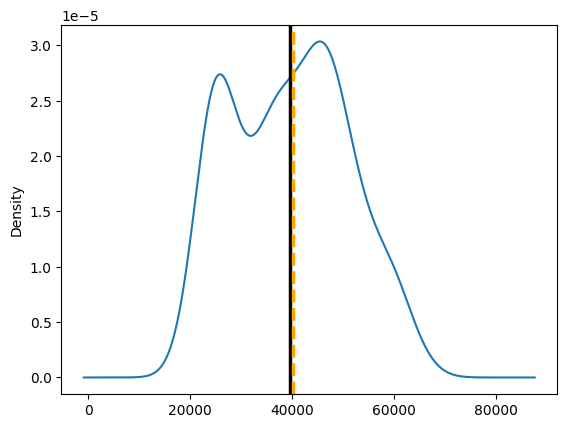

In [9]:
# KDE plot
ax = df['target'].plot(kind='density')
plt.axvline(df['target'].mean(), c='k', ls='-', lw=2.5)
plt.axvline(df['target'].median(), c='orange', ls='--', lw=2.5)

<Axes: >

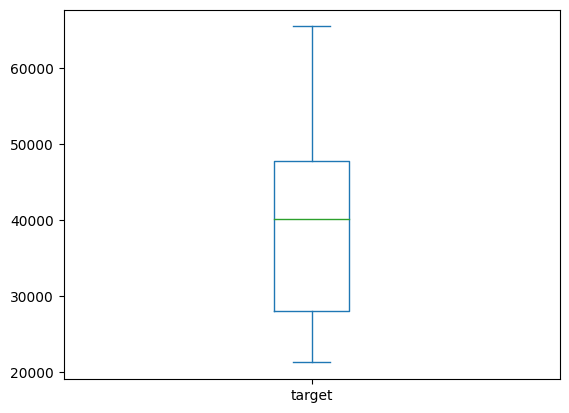

In [ ]:
df['target'].plot(kind='box')

Since the mean and median of the target variable are very close, and there is no outlier, either MAE or RMSE would work

[]

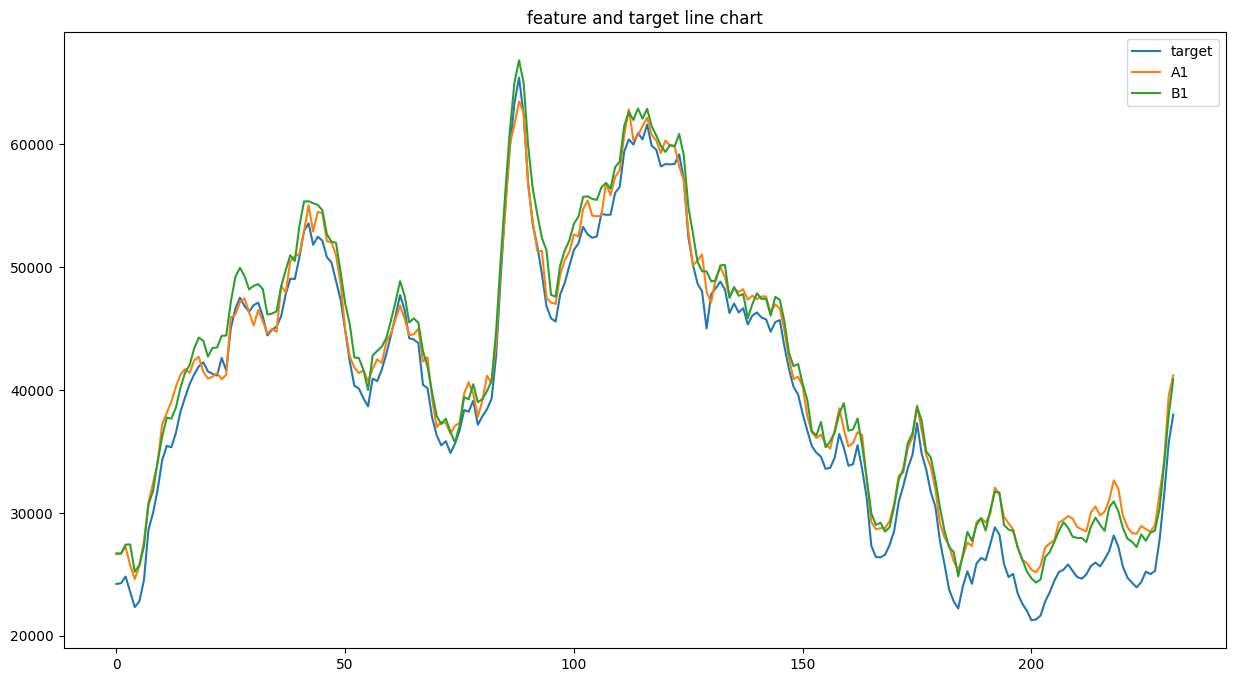

In [3]:
#draw line plot of the features and target variables
df_plot = df[['target','A1','B1']]
lines =df_plot.plot.line(figsize=(15, 8), title = 'feature and target line chart')
lines.legend(bbox_to_anchor=(1.0, 1.0))
lines.plot()

In [4]:
df_plot.corr()

,target,A1,B1
target,1.000000,0.995297,0.998002
A1,0.995297,1.000000,0.995631
B1,0.998002,0.995631,1.000000


Features A1, B1 had very similar trend compared to the target, the correlations between them are also close to one

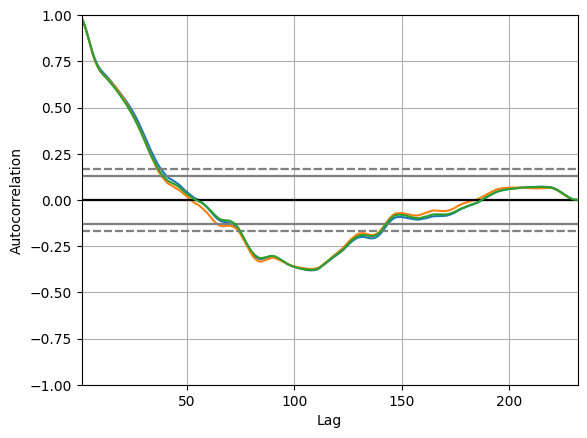

In [48]:
#auto correlation plot
for col in df_plot.columns:
  pd.plotting.autocorrelation_plot(df[col])

All three variables have significant positive autocorrelations from lag 1 to around lag 20

### conduct ADF Test

Since most statistical models require input to be stationary, we first check whether each variable is stationary

In [10]:

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    #print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
print('check variable target')
adf_test(df['target'])
print('\n')

print('check variable A1')
adf_test(df['A1'])
print('\n')

print('check variable B1')
adf_test(df['B1'])
print('\n')

check variable target
Augmented Dickey-Fuller Test: 
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


check variable A1
Augmented Dickey-Fuller Test: 
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


check variable B1
Augmented Dickey-Fuller Test: 
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary




Since all three variables are non-stationary, we take a first-order difference and all three variables become stationary

In [12]:
#take first order difference
df_difference = df[['target','A1','B1']].diff()
df_difference.dropna(inplace = True)

print('check variable target')
adf_test(df_difference['target'])
print('\n')

print('check variable A1')
adf_test(df_difference['A1'])
print('\n')

print('check variable B1')
adf_test(df_difference['B1'])
print('\n')

check variable target
Augmented Dickey-Fuller Test: 
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


check variable A1
Augmented Dickey-Fuller Test: 
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


check variable B1
Augmented Dickey-Fuller Test: 
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary




## Statistical Method - Vector Autoregression

In [13]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###
def cycle_encode(data, cols):

    for col in cols:

        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data

In [16]:
#create exogenous features
df_difference['date'] = pd.to_datetime(df.date , format = '%m/%d/%y')
df_difference.set_index('date', inplace=True)

df_external = pd.DataFrame(df_difference.index)
df_external['year'] = df_external.date.dt.year
df_external['month'] = df_external.date.dt.month

df_external['week'] = df_external.date.dt.strftime('%V').astype('int')
df_external = cycle_encode(df_external, ['year','month','week'])

df_external.drop(['year','month','week'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()


(231, 6)


,year_sin,year_cos,month_sin,month_cos,week_sin,week_cos
date,,,,,,
2018-08-24,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.776524,-0.630088
2018-08-31,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.845596,-0.533823
2018-09-07,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.902798,-0.430065
2018-09-14,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.947326,-0.320270
2018-09-21,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.978556,-0.205979


Check the granger casality among variables

In [18]:

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_difference, variables = df_difference.columns)

,target_x,A1_x,B1_x
target_y,1.0,0.0097,0.0878
A1_y,0.0,1.0000,0.0000
B1_y,0.0,0.0000,1.0000


In [19]:
df_full = pd.concat([df_difference, df_external], axis = 1)
grangers_causation_matrix(df_full, variables = df_full.columns)

,target_x,A1_x,B1_x,year_sin_x,year_cos_x,month_sin_x,month_cos_x,week_sin_x,week_cos_x
target_y,1.0000,0.0097,0.0878,0.4435,0.2331,0.2964,0.5252,0.7406,0.4940
A1_y,0.0000,1.0000,0.0000,0.5890,0.3971,0.2726,0.5327,0.1708,0.5478
B1_y,0.0000,0.0000,1.0000,0.6137,0.4055,0.3907,0.5436,0.4120,0.4826
year_sin_y,0.3087,0.4364,0.8374,1.0000,0.5812,0.0000,0.0000,0.0043,0.0015
year_cos_y,0.1104,0.4194,0.6075,0.5459,1.0000,0.0000,0.0007,0.0257,0.0076
month_sin_y,0.7172,0.4446,0.3859,0.5038,0.3918,1.0000,0.0000,0.0000,0.0000
month_cos_y,0.3867,0.5096,0.1486,0.1305,0.1783,0.0000,1.0000,0.0000,0.0000
week_sin_y,0.2421,0.4092,0.3121,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
week_cos_y,0.1595,0.1567,0.1467,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


From causality analysis, we could conclude that A1, B1 have more contribution to the price movement of the target than the other external covariates

In [21]:
#split into train and test

max_prediction_length = 12

my_train_size = (len(df_difference)-max_prediction_length)/len(df_difference)
train, test = train_test_split(df_difference, shuffle=False, train_size=my_train_size)
train_ext, test_ext = train_test_split(df_external, shuffle=False, train_size=my_train_size)

print(train.shape, test.shape)
print(train_ext.shape, test_ext.shape)

(219, 3) (12, 3)
(219, 6) (12, 6)


### Start building VAR model

#### Select order p for the VAR Model

In [22]:
#use model.select_order to choose the optimal lag
model = VAR(endog=train.values)
x = model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,41.43,41.48,9.795e+17,41.45
1,40.65,40.86,4.519e+17,40.74
2,40.46,40.82*,3.716e+17,40.60
3,40.39,40.90,3.479e+17,40.60
4,40.34,41.00,3.294e+17,40.61
5,40.24*,41.06,2.993e+17*,40.57*
6,40.24,41.22,3.013e+17,40.64
7,40.29,41.42,3.149e+17,40.75
8,40.33,41.62,3.298e+17,40.85
9,40.38,41.82,3.471e+17,40.97


From above, we can see the optimal lag is 5

In [26]:
### FIND BEST VAR ORDER based solely on AIC###
AIC = {}
best_aic, best_order = np.inf, 0
max_lag = 30
best_model = None
for i in tqdm(range(1,max_lag)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i, trend = 'ct')
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        best_model = model

print('\n')
print('BEST ORDER:', best_order, 'BEST AIC:', '{:.4f}'.format(best_aic))

100%|██████████| 29/29 [00:00<00:00, 353.39it/s]



BEST ORDER: 6 BEST AIC: 40.3487


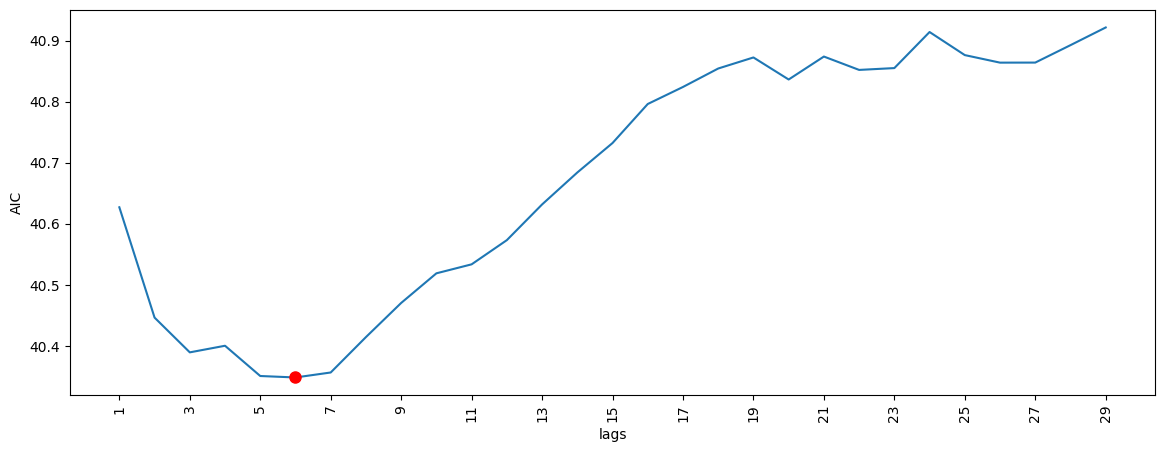

In [65]:
### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,max_lag, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

Since lag 5 and lag 6 have the same AIC values, while lag 5 has better value at other metrics, we choose lag 5 as the optimal lag

In [33]:
#include exogeneous features
model2 = VAR(endog=train.values,exog = train_ext.values)
x2 = model2.select_order(maxlags=30)
x2.summary()

,AIC,BIC,FPE,HQIC
0,41.58,41.95,1.149e+18,41.73
1,40.81,41.32,5.291e+17,41.02
2,40.60,41.27*,4.306e+17,40.87
3,40.53,41.35,4.001e+17,40.86
4,40.47,41.45,3.764e+17,40.86
5,40.36,41.50,3.396e+17*,40.82*
6,40.36*,41.65,3.398e+17,40.88
7,40.40,41.84,3.520e+17,40.98
8,40.44,42.04,3.698e+17,41.09
9,40.48,42.23,3.867e+17,41.19


The optimal lag is still about 5 if including exogeneous features

<Axes: >

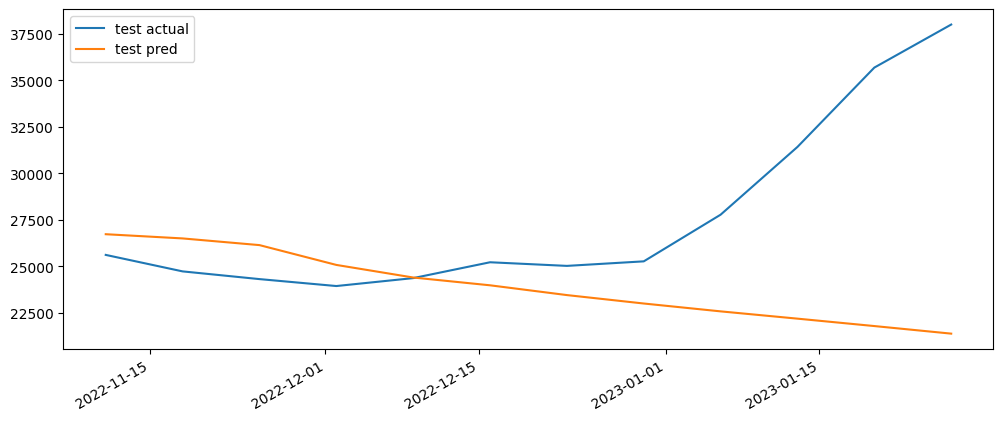

In [23]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###
#no exogeneous features
#var = VAR(endog=train.values,exog = train_ext.values)
best_order = 5
var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order, trend = 'ct')
lag_order = var_result.k_ar
#y_pred = var_result.forecast(train.values[-lag_order:], exog_future = test_ext.values, steps=len(test))
y_pred = var_result.forecast(train.values[-lag_order:], steps=len(test))

#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(y_pred)),columns=test.columns)
for j in range(0,len(test.columns)):
    for i in range(0, len(y_pred)):
       pred.iloc[i][j] = y_pred[i][j]

pred.set_index(test.index, inplace=True)

#append prediction to train
frames = [train,pred]
actual_and_pred = pd.concat(frames)
actual_and_pred.tail()

#inverse transform first order difference back
df_pred_rev = actual_and_pred.cumsum().add(df.iloc[0, :])
df_pred_rev = pd.concat([df.iloc[0:1, :], df_pred_rev])

#append test to train
#inverse transform first order difference back
actuals = pd.concat([train,test])
df_act_rev = actuals.cumsum().add(df.iloc[0, :])
df_act_rev = pd.concat([df.iloc[0:1, :], df_act_rev])

test_rev = df_act_rev[-max_prediction_length:]
test_rev['target'].plot(figsize=(12,5),label='test actual', legend = True)
pred_rev = df_pred_rev[-max_prediction_length:]
pred_rev['target'].plot(label='test pred', legend = True)

In [71]:
#check rmse
#for i in test_rev.columns:
#    print('rmse value for', i, 'is : ', '{:.4f}'.format(np.sqrt(mean_squared_error(pred_rev[i], test_rev[i]))))

#check mae
print('mae value for target is : ', '{:.4f}'.format(mean_absolute_error(pred_rev['target'], test_rev['target'])))
#check mape
print('mape value for target is : ', '{:.4f}'.format(mean_absolute_percentage_error(test_rev['target'],pred_rev['target'])))

mae value for target is :  5051.1915
mape value for target is :  0.1593


Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [24]:

out = durbin_watson(var_result.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df_difference.columns, out):
    print(adjust(col), ':', round(val, 2))

target : 2.1
A1     : 2.05
B1     : 2.05


The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

<Axes: >

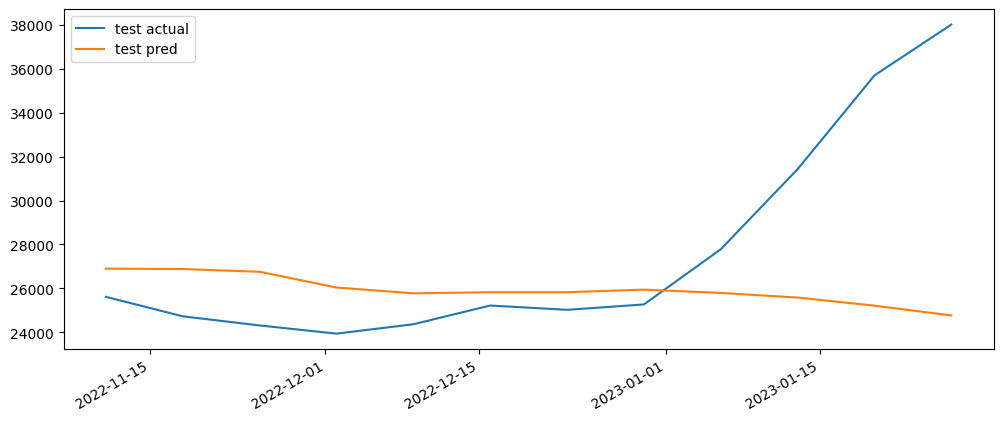

In [34]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###
#include exogeneous features
var = VAR(endog=train.values,exog = train_ext.values)
best_order = 5
var_result = var.fit(maxlags=best_order, trend = 'ct')
lag_order = var_result.k_ar
y_pred = var_result.forecast(train.values[-lag_order:], exog_future = test_ext.values, steps=len(test))

#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(y_pred)),columns=test.columns)
for j in range(0,len(test.columns)):
    for i in range(0, len(y_pred)):
       pred.iloc[i][j] = y_pred[i][j]

pred.set_index(test.index, inplace=True)

#append prediction to train
frames = [train,pred]
actual_and_pred = pd.concat(frames)
actual_and_pred.tail()

#inverse transform first order difference back
df_pred_rev = actual_and_pred.cumsum().add(df.iloc[0, :])
df_pred_rev = pd.concat([df.iloc[0:1, :], df_pred_rev])

#append test to train
#inverse transform first order difference back
actuals = pd.concat([train,test])
df_act_rev = actuals.cumsum().add(df.iloc[0, :])
df_act_rev = pd.concat([df.iloc[0:1, :], df_act_rev])

test_rev = df_act_rev[-max_prediction_length:]
test_rev['target'].plot(figsize=(12,5),label='test actual', legend = True)
pred_rev = df_pred_rev[-max_prediction_length:]
pred_rev['target'].plot(label='test pred', legend = True)

From visualization, we can see that VAR model fails to capture dynamics in target in longer terms even after including exogeneous features

In [35]:
print('after including exogeneous features: ')
#check mae
print('mae value for target is : ', '{:.4f}'.format(mean_absolute_error(pred_rev['target'], test_rev['target'])))
#check mape
print('mape value for target is : ', '{:.4f}'.format(mean_absolute_percentage_error(test_rev['target'],pred_rev['target'])))

after including exogeneous features: 
mae value for target is :  3584.5320
mape value for target is :  0.1138


MAE improved from 5051.1915 to 3584.5320,
and mape value improved from 0.1593 to 0.1138

## Deep Learning -- Temporal Fusion Transformer
### Prepare data for TimeSeriesDataSet format

In [35]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)
df = (df.merge((df[['date']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['date']))

#convert date column to index
df['date'] = pd.to_datetime(df.date , format = '%m/%d/%y')
df.set_index('date', inplace=True)
df.head()

,target,A1,B1,time_idx
date,,,,
2018-08-17,24218,26639.85932,26712.400,0
2018-08-24,24276,26732.24945,26670.446,1
2018-08-31,24825,27234.12799,27424.310,2
2018-09-07,23583,25763.61542,27435.742,3
2018-09-14,22333,24621.30913,25207.102,4


In [36]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###
def cycle_encode(data, cols):

    for col in cols:

        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data

In [37]:
df_external = pd.DataFrame(df.index)

df_external['year'] = df_external.date.dt.year
df_external['month'] = df_external.date.dt.month

df_external['week'] = df_external.date.dt.strftime('%V').astype('int')
df_external = cycle_encode(df_external, ['year','month','week'])

df_external.drop(['year','month','week'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

#print(df_external.shape)
df_external.head()


,year_sin,year_cos,month_sin,month_cos,week_sin,week_cos
date,,,,,,
2018-08-17,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.696551,-0.717507
2018-08-24,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.776524,-0.630088
2018-08-31,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.845596,-0.533823
2018-09-07,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.902798,-0.430065
2018-09-14,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.947326,-0.320270


In [38]:
#concatenate original features and newly created features
df_full = pd.concat([df, df_external], axis = 1)
df_full["group_ids"] = 'target'
df_full.head()

,target,A1,B1,time_idx,year_sin,year_cos,month_sin,month_cos,week_sin,week_cos,group_ids
date,,,,,,,,,,,
2018-08-17,24218,26639.85932,26712.400,0,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.696551,-0.717507,target
2018-08-24,24276,26732.24945,26670.446,1,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.776524,-0.630088,target
2018-08-31,24825,27234.12799,27424.310,2,-0.015529,0.999879,-0.866025,-5.000000e-01,-0.845596,-0.533823,target
2018-09-07,23583,25763.61542,27435.742,3,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.902798,-0.430065,target
2018-09-14,22333,24621.30913,25207.102,4,-0.015529,0.999879,-1.000000,-1.836970e-16,-0.947326,-0.320270,target


### Set up TemporalFusionTransformer model

In [39]:

max_prediction_length = 12
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_full[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=["group_ids"],
    static_categoricals=["group_ids"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=list(df_external.columns)+ ['time_idx','A1','B1'],
    time_varying_unknown_reals=['target'],
    target_normalizer=GroupNormalizer(
        groups=["group_ids"], transformation=None
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df_full, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 16
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
#val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [42]:
#Baseline model
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
print('Baseline MAE: ',MAE()(baseline_predictions.output, baseline_predictions.y))
print('Baseline MAPE: ',MAPE()(baseline_predictions.output, baseline_predictions.y))

Baseline MAE:  tensor(3615.5000)
Baseline MAPE:  tensor(0.1217)


### Hyperparameter tuning

In [ ]:
"""
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)
"""

### Load set of optimal hyperparameters after tuning

In [25]:
best_params = {'gradient_clip_val': 0.013892935462669497, 'hidden_size': 8, 'dropout': 0.22354445137955084, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.005182858220429759}

In [26]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("best_logs_lookback_24_prediction_12_batch_16_delta_1e-2")

trainer = pl.Trainer(
    max_epochs=50,
    #accelerator='gpu',
    accelerator='cpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=best_params['gradient_clip_val'],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params['learning_rate'],
    hidden_size=best_params['hidden_size'],
    attention_head_size=best_params['attention_head_size'],
    dropout=best_params['dropout'],
    hidden_continuous_size=best_params['hidden_continuous_size'],
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [27]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved. New best score: 11312.657
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 11312.657


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 1507.756 >= min_delta = 0.01. New best score: 9804.901
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1507.756 >= min_delta = 0.01. New best score: 9804.901


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 555.634 >= min_delta = 0.01. New best score: 9249.268
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 555.634 >= min_delta = 0.01. New best score: 9249.268


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 483.830 >= min_delta = 0.01. New best score: 8765.438
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 483.830 >= min_delta = 0.01. New best score: 8765.438


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 593.402 >= min_delta = 0.01. New best score: 8172.036
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 593.402 >= min_delta = 0.01. New best score: 8172.036


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 582.938 >= min_delta = 0.01. New best score: 7589.098
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 582.938 >= min_delta = 0.01. New best score: 7589.098


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 778.206 >= min_delta = 0.01. New best score: 6810.892
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 778.206 >= min_delta = 0.01. New best score: 6810.892


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 690.808 >= min_delta = 0.01. New best score: 6120.084
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 690.808 >= min_delta = 0.01. New best score: 6120.084


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 435.829 >= min_delta = 0.01. New best score: 5684.255
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 435.829 >= min_delta = 0.01. New best score: 5684.255


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 513.307 >= min_delta = 0.01. New best score: 5170.949
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 513.307 >= min_delta = 0.01. New best score: 5170.949


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 550.920 >= min_delta = 0.01. New best score: 4620.029
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 550.920 >= min_delta = 0.01. New best score: 4620.029


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 422.649 >= min_delta = 0.01. New best score: 4197.379
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 422.649 >= min_delta = 0.01. New best score: 4197.379


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 697.078 >= min_delta = 0.01. New best score: 3500.302
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 697.078 >= min_delta = 0.01. New best score: 3500.302


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 324.128 >= min_delta = 0.01. New best score: 3176.174
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 324.128 >= min_delta = 0.01. New best score: 3176.174


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 295.366 >= min_delta = 0.01. New best score: 2880.807
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 295.366 >= min_delta = 0.01. New best score: 2880.807


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 299.514 >= min_delta = 0.01. New best score: 2581.293
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 299.514 >= min_delta = 0.01. New best score: 2581.293


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 210.810 >= min_delta = 0.01. New best score: 2370.483
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 210.810 >= min_delta = 0.01. New best score: 2370.483


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 192.102 >= min_delta = 0.01. New best score: 2178.381
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 192.102 >= min_delta = 0.01. New best score: 2178.381


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 185.578 >= min_delta = 0.01. New best score: 1992.803
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 185.578 >= min_delta = 0.01. New best score: 1992.803


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 198.297 >= min_delta = 0.01. New best score: 1794.505
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 198.297 >= min_delta = 0.01. New best score: 1794.505


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 82.225 >= min_delta = 0.01. New best score: 1712.281
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 82.225 >= min_delta = 0.01. New best score: 1712.281


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 444.083 >= min_delta = 0.01. New best score: 1268.198
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 444.083 >= min_delta = 0.01. New best score: 1268.198


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 259.958 >= min_delta = 0.01. New best score: 1008.240
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 259.958 >= min_delta = 0.01. New best score: 1008.240


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 1008.240. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1008.240. Signaling Trainer to stop.


In [43]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

#Evaluate on Training data
train_evaluation_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

actuals = torch.cat([y[0] for x, y in iter(train_evaluation_dataloader)])#.to("cuda")
predictions = best_tft.predict(train_evaluation_dataloader)

#average p50 loss overall
print('Best Regression Model Training MAE:','{:.4f}'.format((actuals - predictions).abs().nanmean().item()))
print('Best Regression Model Training MAPE:','{:.4f}'.format((actuals/predictions-1).abs().nanmean().item()))


best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/checkpoints/epoch=27-step=392.ckpt
Best Regression Model Training MAE: 1454.1864
Best Regression Model Training MAPE: 0.0415


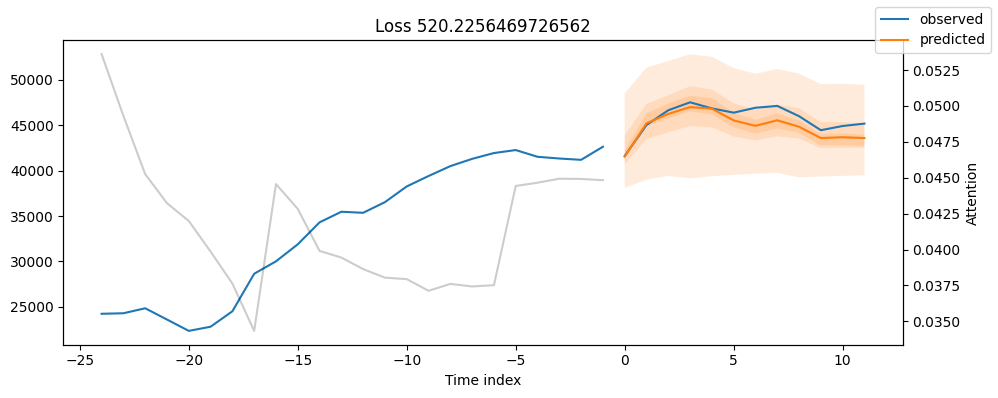

In [44]:
#plot on Training data evaluation
for group in ['target']:
    raw_prediction= best_tft.predict(
    training.filter(lambda x: (x.group_ids == group)),
    mode="raw",
    return_x=True,
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, add_loss_to_title=QuantileLoss(),ax=ax)

From visualization, we can see that the TFT Model performed well on the training dataset

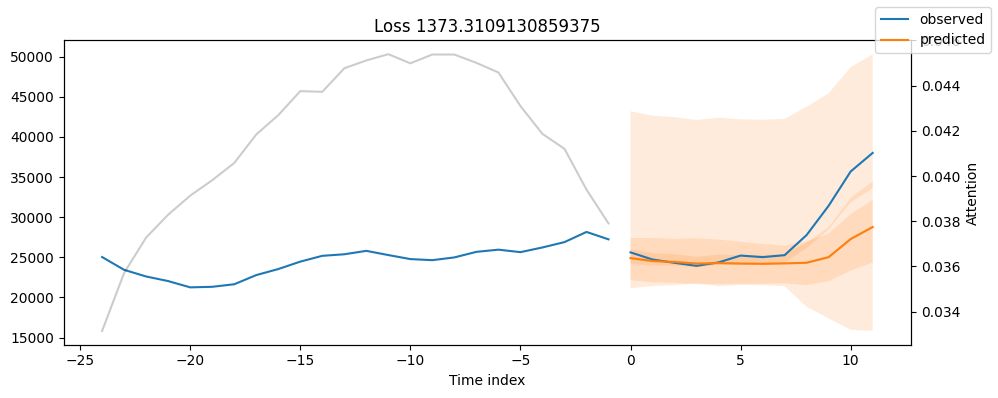

In [31]:
# plot evaluation on validation data
for group in ['target']:
    raw_prediction= best_tft.predict(
    validation.filter(lambda x: (x.group_ids == group)),
    mode="raw",
    return_x=True,
    )
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0, add_loss_to_title=QuantileLoss(),ax=ax)

From visualization, we can see that the TFT Model was able to capture dynamics of the validatin datset

## Evaluate on validation data across models

In [72]:
#Evaluate on validation data across models
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
print('Best Regression Model Validation MAE:',MAE()(predictions.output, predictions.y))
print('Best Regression Model Validation MAPE:',MAPE()(predictions.output, predictions.y))

print('Baseline MAE: ',MAE()(baseline_predictions.output, baseline_predictions.y))
print('Baseline MAPE: ',MAPE()(baseline_predictions.output, baseline_predictions.y))

#check mae
print('VAR mae value for target is : ', '{:.4f}'.format(mean_absolute_error(pred_rev['target'], test_rev['target'])))
#check mape
print('VAR mape value for target is : ', '{:.4f}'.format(mean_absolute_percentage_error(test_rev['target'],pred_rev['target'])))

Best Regression Model Validation MAE: tensor(2645.0388)
Best Regression Model Validation MAPE: tensor(0.0813)
Baseline MAE:  tensor(3615.5000)
Baseline MAPE:  tensor(0.1217)
VAR mae value for target is :  5051.1915
VAR mape value for target is :  0.1593


Conclusion: Temporal Fusion Transformer's performance (0.0813) on the validation dataset is better than both the Baseline Model (0.1217), and the VAR model including exogeneous features (0.1138)

Save the Model

In [32]:
#zip and download the model
!zip  -r best_reg_onetarget_model.zip best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/*

  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/00392/ (stored 0%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/00392/group_ids/ (stored 0%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/00392/group_ids/tensors.tsv (stored 0%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/00392/group_ids/metadata.tsv (stored 0%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/checkpoints/epoch=27-step=392.ckpt (deflated 56%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/events.out.tfevents.1689596711.4821f2181615.152.1 (deflated 12%)
  adding: best_logs_lookback_24_prediction_12_batch_16_delta_1e-2/lightning_logs/version_0/hpa